# Environment

In [62]:
import gc 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from datetime import datetime
import importlib

import celloracle as co
importlib.reload(co)
from celloracle import *

sys.path.insert(0, "/home/michal.kubacki/Githubs/Re-MEND/code/External_Datasets/GeneSet_Derivation/Herring_celloracle/helpers")

import config
importlib.reload(config)
from config import *
n_cpus = 32

In [63]:
reference = "hg19"

neurons_set = "all_inhibitory_all_ages"
# neurons_set = "all_inhibitory"

cells_dict = {
    "all_inhibitory"            :   ['SST', 'VIP', 'MGE_dev'],
    "all_inhibitory_all_ages"   :   ['VIP', 'SST', 'PV', 'MGE_dev']
}

ages_dict = {
    "all_inhibitory"            :   ['1m','3m','6m','10m','1y','2y','4y','ga22','ga24'],
    "all_inhibitory_all_ages"   :   ['1m','3m','6m','10m','1y','2y','4y','6y','10y','16y','20y','40y','ga22','ga24']
}

output_dir, input_dir, root_dir, tmp_dir, in_dir_from_scenic = set_custom_folders(reference, neurons_set)

sel_celltypes  = cells_dict[neurons_set]
sel_ages = ages_dict[neurons_set]

root_dir: /group/testa/michal.kubacki/herring
out_dir: /group/testa/michal.kubacki/herring/output_hg19_all_inhibitory_all_ages/celloracle
in_dir: /group/testa/michal.kubacki/herring/data
tmp_dir: /group/testa/michal.kubacki/herring/celloracle/tmp


In [64]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Load the data

In [65]:
oracle_file_name = os.path.join(output_dir, "oracle_1.celloracle.oracle")
links_file_name = os.path.join(output_dir, "links_1.celloracle.links")

In [66]:
oracle = co.load_hdf5(oracle_file_name)

ValueError: File not found. Please check if the file_path is correct.

In [ ]:
links = co.load_hdf5(links_file_name)

In [ ]:
links

In [ ]:
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)

In [ ]:
gc.collect()

871

# Fit GRNs

In [ ]:
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
# current_datetime = ""
# file_name = os.path.join(output_dir, f"Herring_simulation.celloracle.oracle")

In [ ]:
# oracle.to_hdf5(file_name)

In [ ]:
# current_datetime = ""
# file_name = f'{folder}Herring_simulation.celloracle.oracle'
# oracle = co.load_hdf5(file_name)

In [ ]:
oracle.adata.obs.major_clust.unique()

['MGE_dev', 'VIP', 'PV', 'SST']
Categories (4, object): ['VIP', 'SST', 'PV', 'MGE_dev']

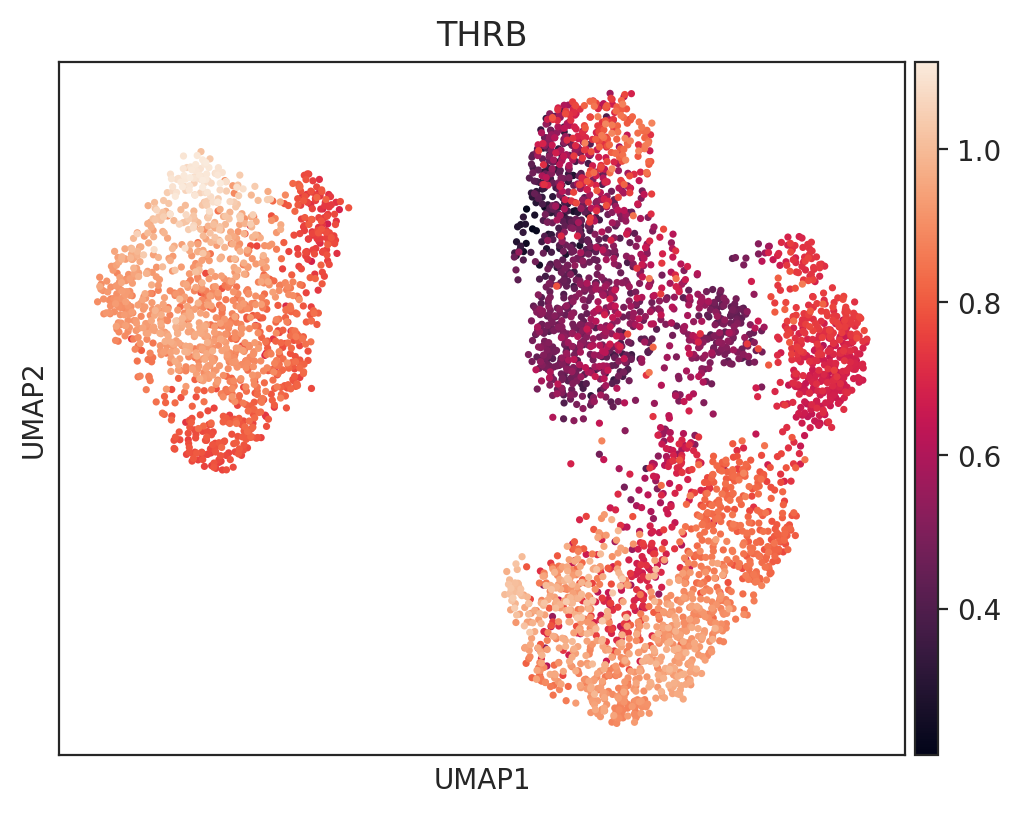

In [ ]:
goi = "THRB"

sc.pl.umap(oracle.adata, color = [goi], layer="imputed_count")

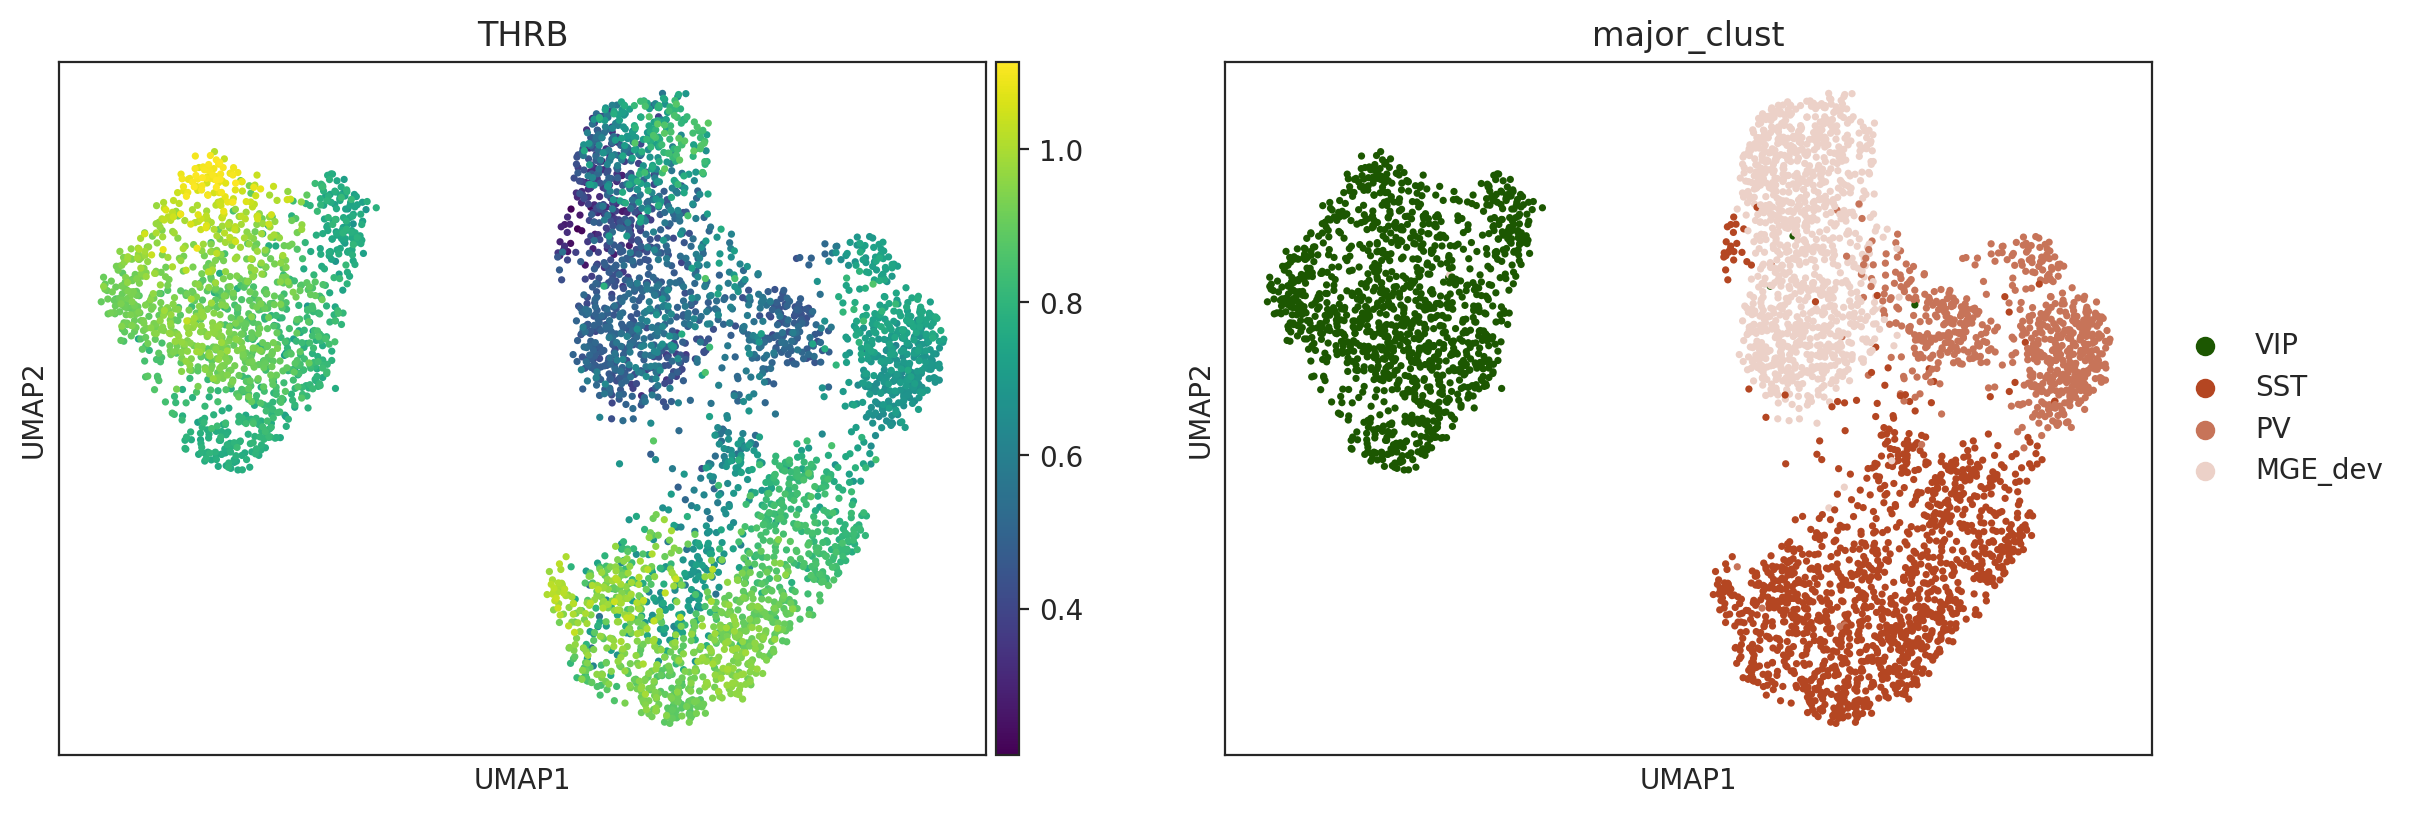

In [ ]:
sc.pl.umap(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

In [ ]:
gc.collect()

6610

# Run simulation

In [ ]:
goi = "THRB"

print(oracle.all_regulatory_genes_in_TFdict[:10])
print(len(oracle.all_regulatory_genes_in_TFdict))
print(goi in oracle.all_regulatory_genes_in_TFdict)

['AC023509.3', 'AC138696.1', 'ADSL', 'AHR', 'AIRE', 'AKAP8', 'ALX1', 'ALX3', 'ALX4', 'ANHX']
1076
True


In [ ]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [ ]:
gc.collect()

50

In [ ]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

In [ ]:
gc.collect()

14303

In [ ]:
# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

In [ ]:
# file_name = os.path.join(output_dir, f"Herring_simulation_{goi}.celloracle.oracle")
# oracle.to_hdf5(file_name)

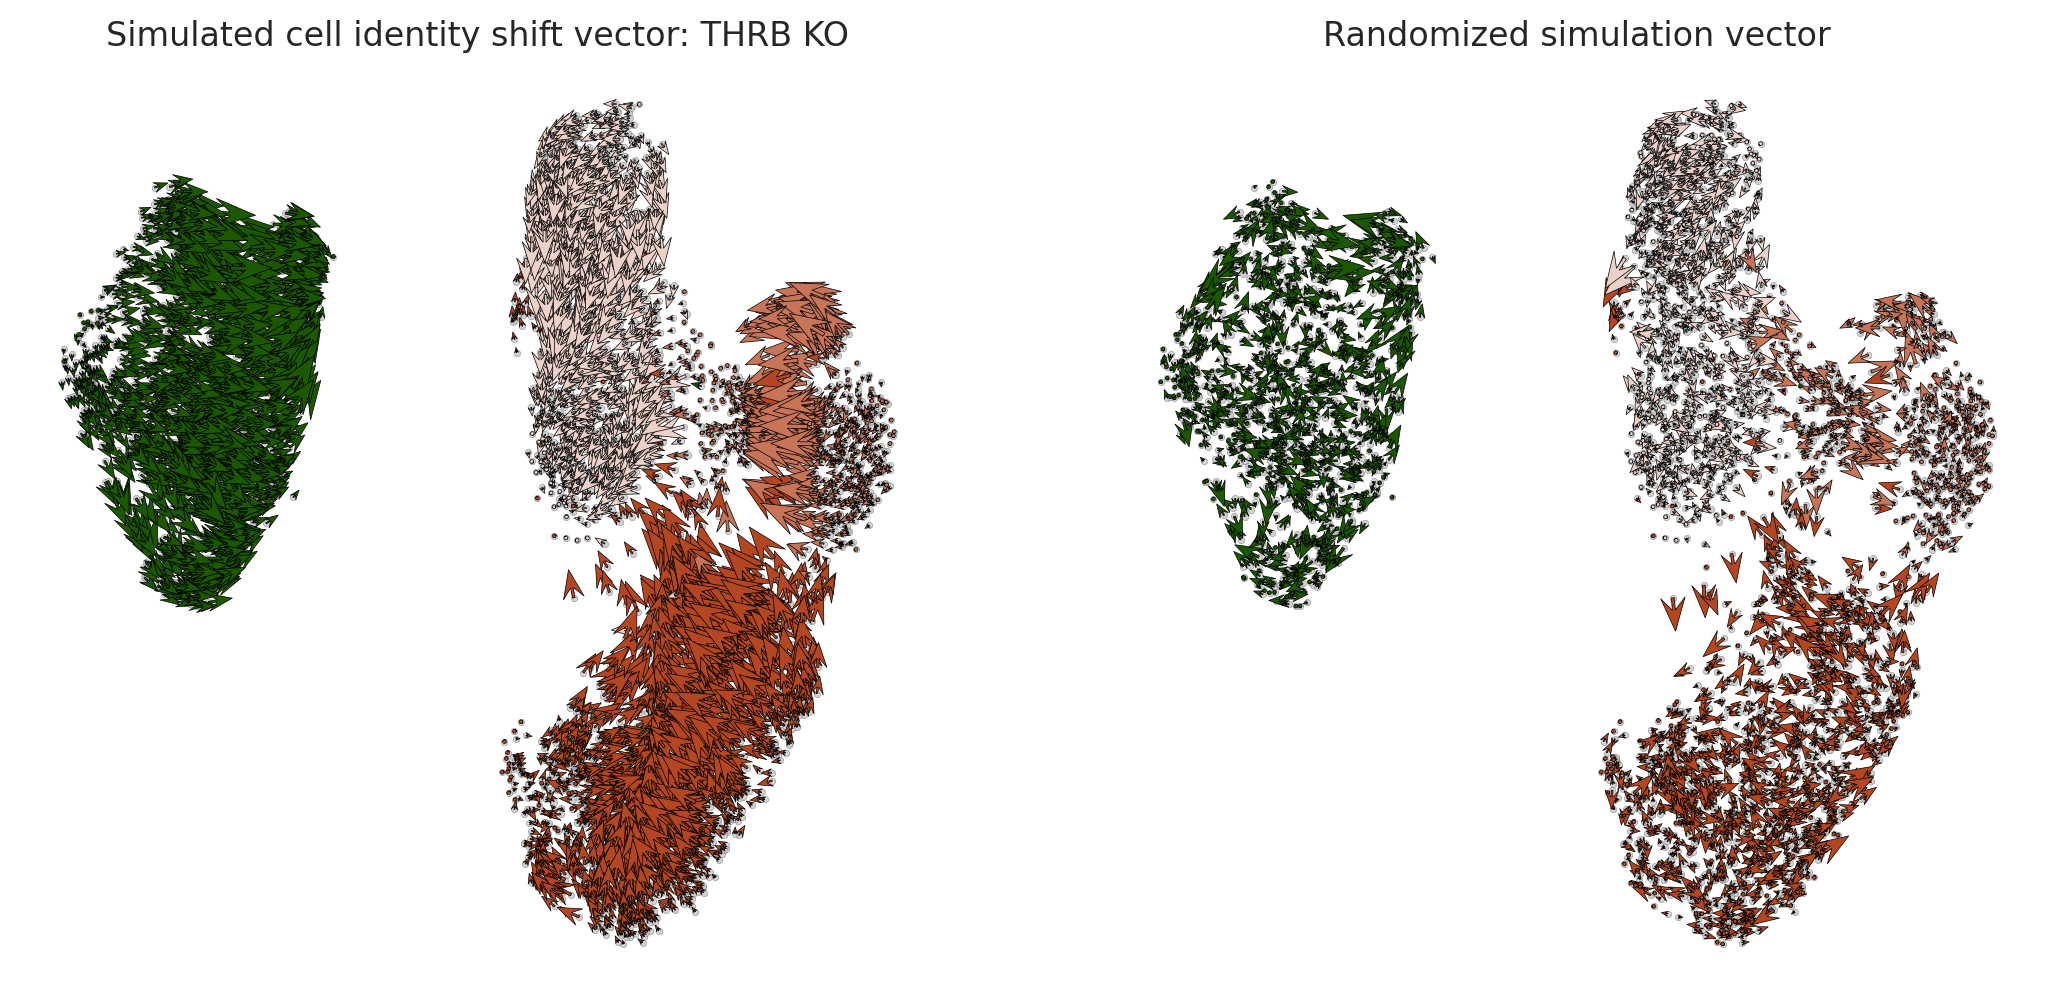

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 20
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

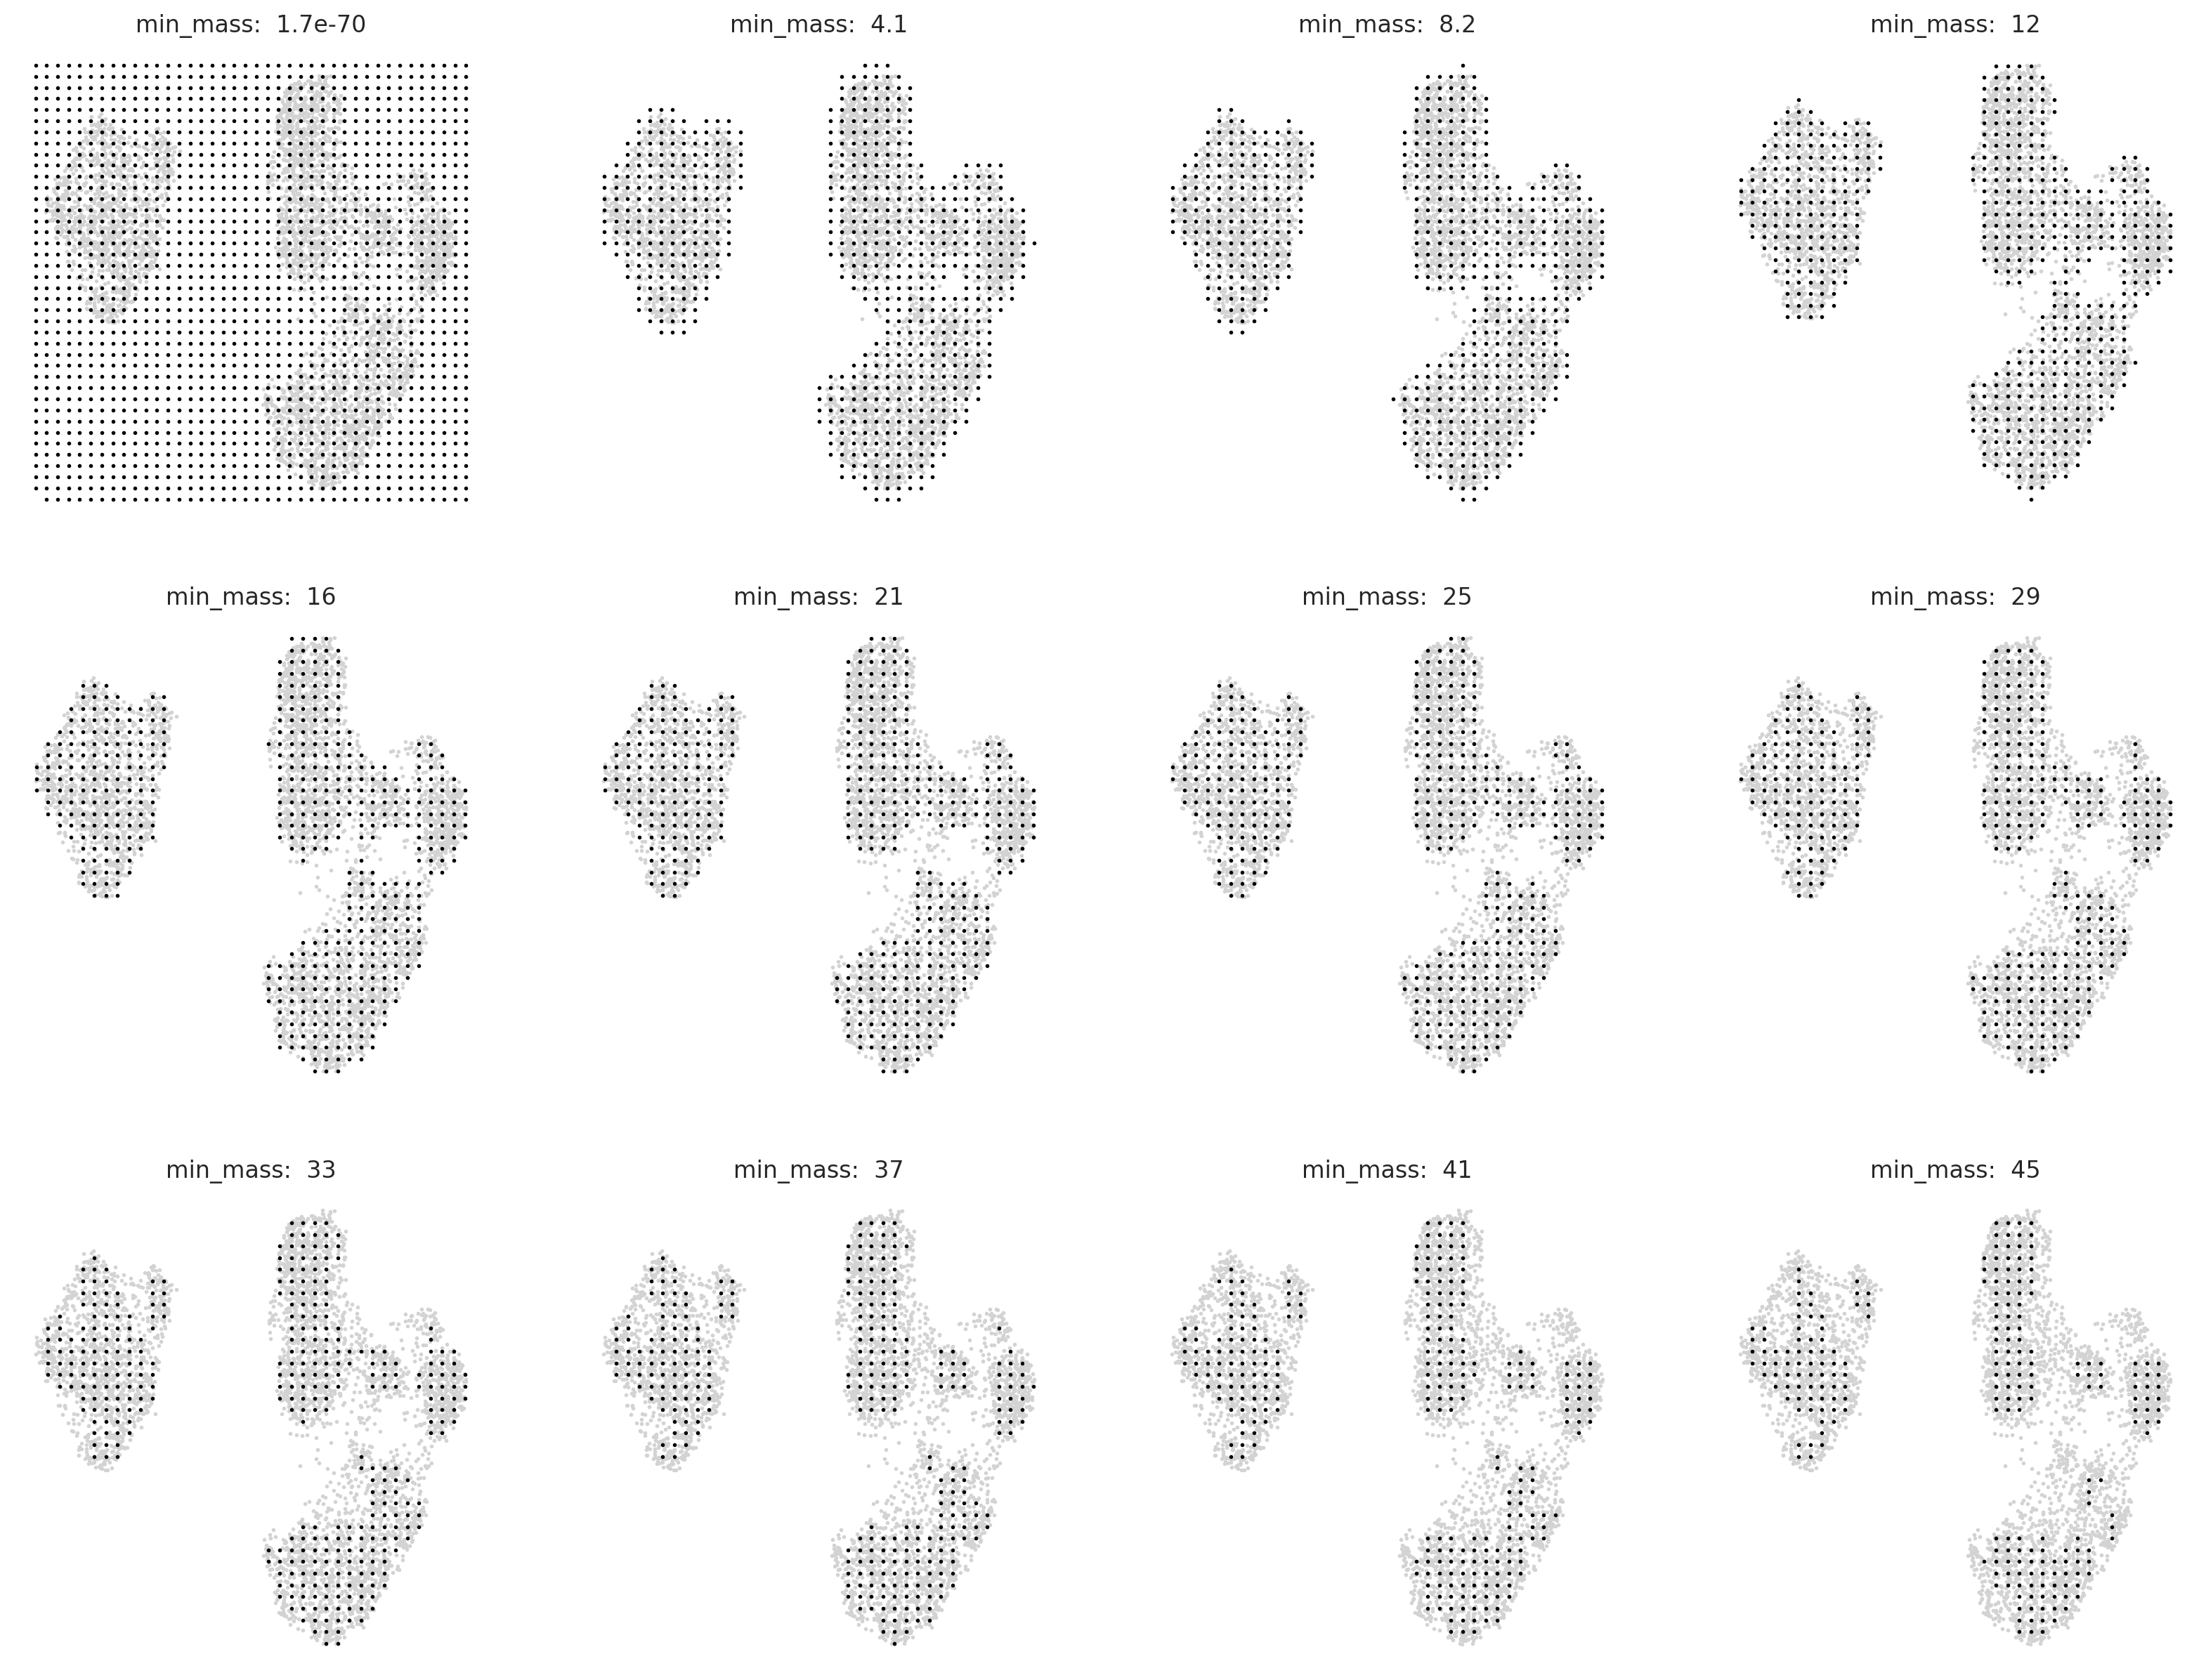

In [ ]:
oracle.suggest_mass_thresholds(n_suggestion=12)

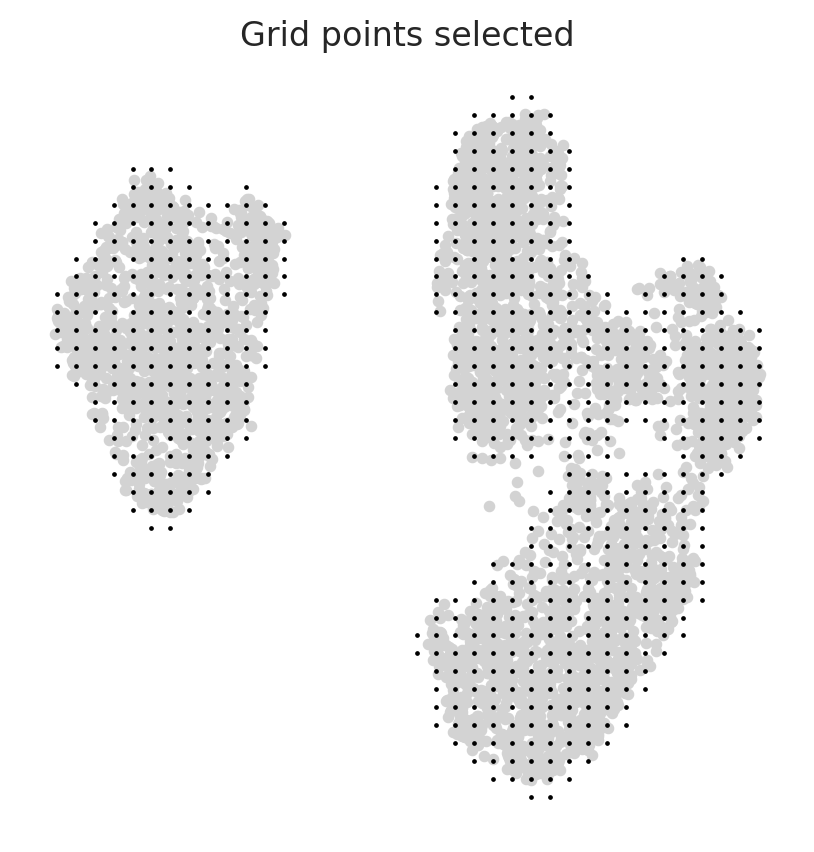

In [ ]:
min_mass = 7
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

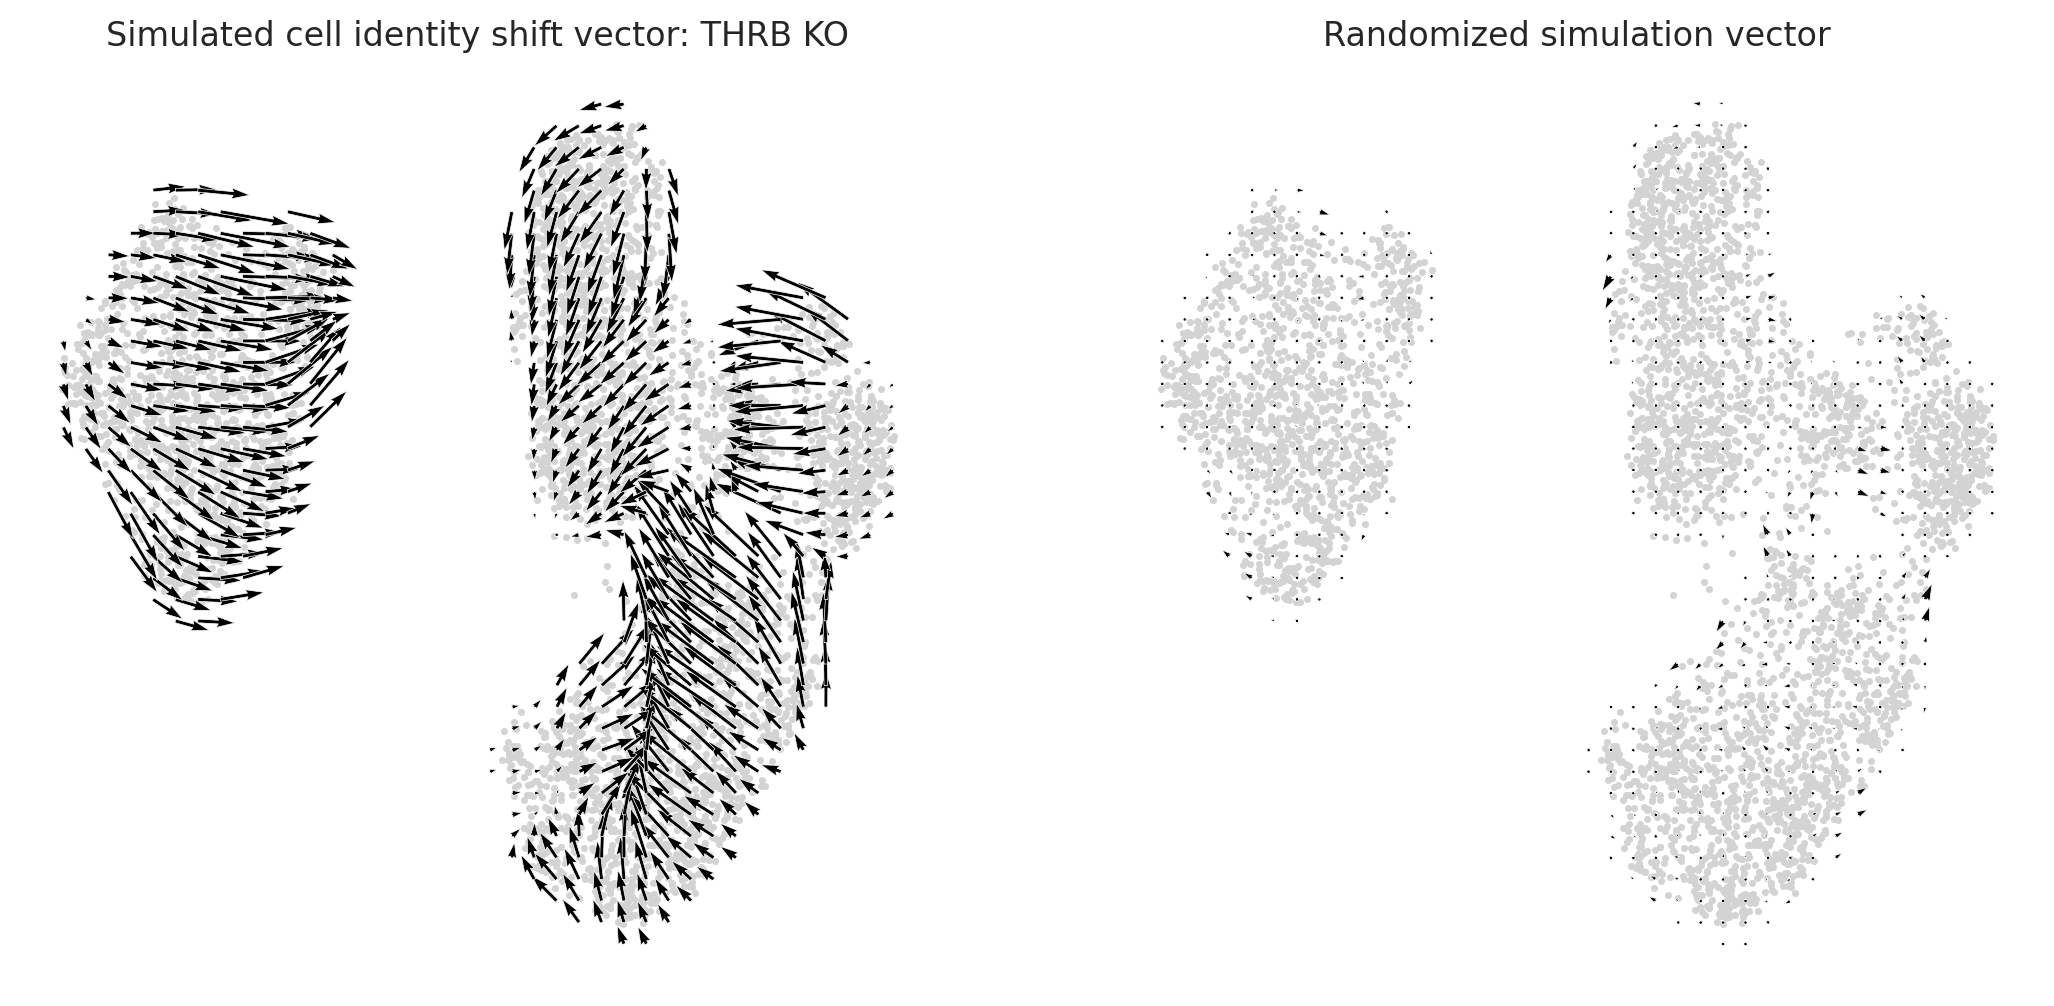

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 10
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

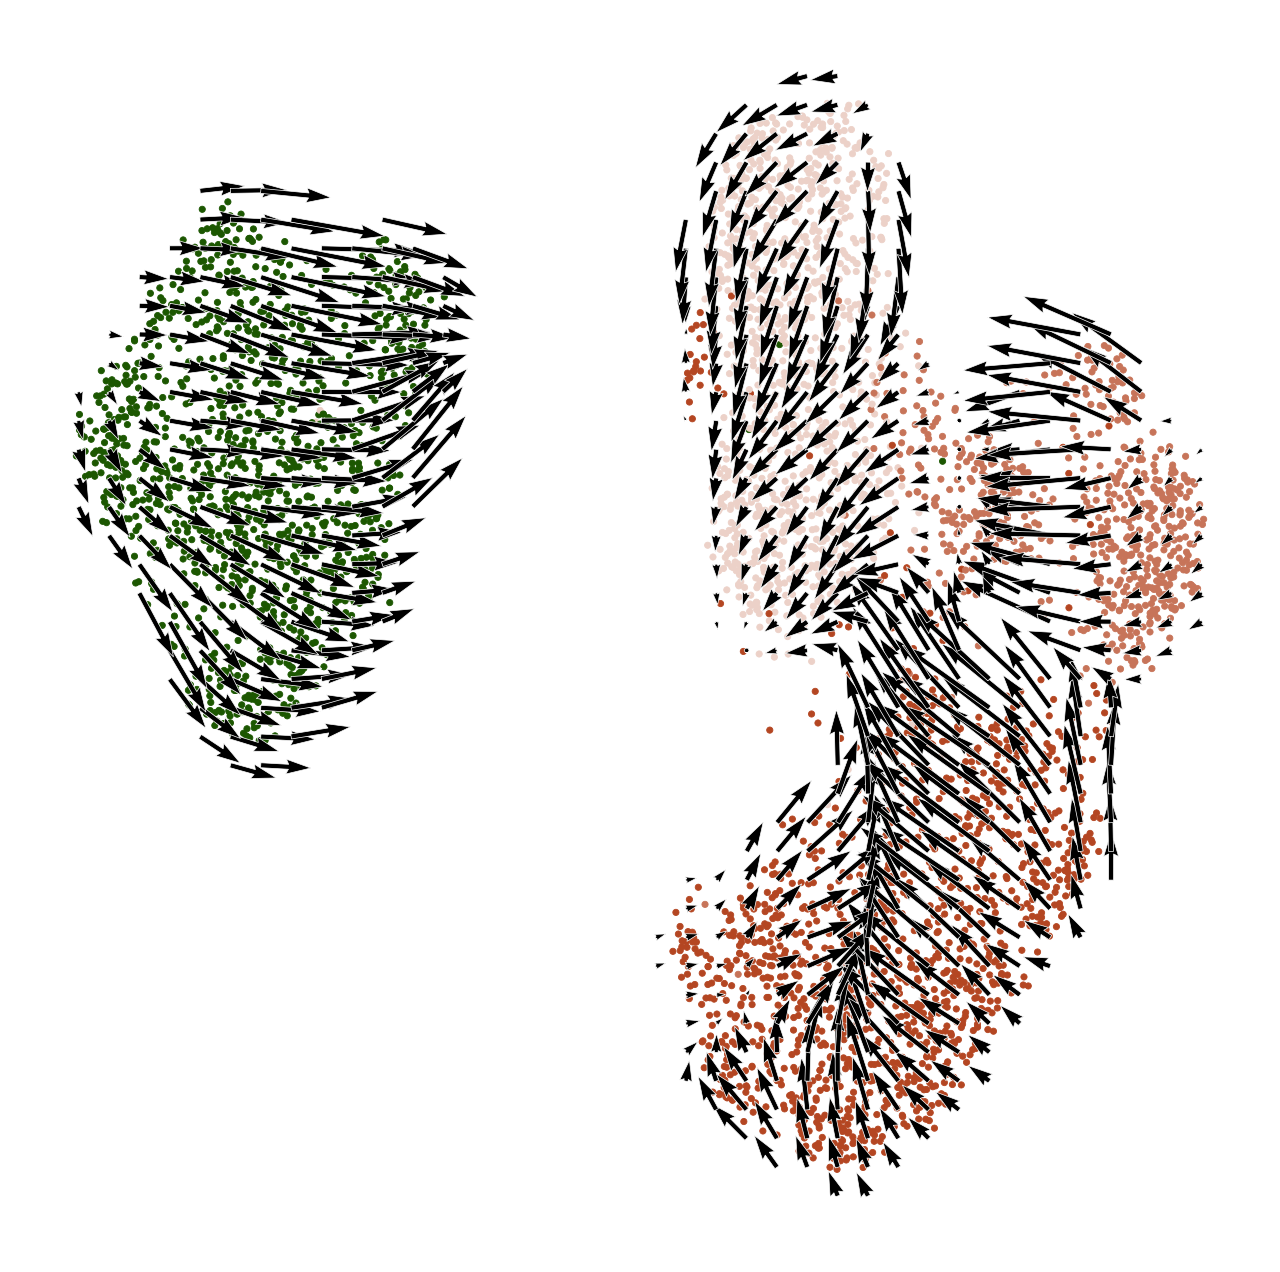

In [ ]:
# Plot vector field with cell cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=5)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

In [ ]:
def plot_arrows_legend(oracle, labels=None, colormap='viridis', scale=1, data_random=False, points_size=5, filename=None):
    fig, ax = plt.subplots(figsize=[8, 8])

    embedding = oracle.adata.obsm['X_umap']
    cluster_labels = oracle.adata.obs[labels]
    cluster_categories = pd.Categorical(cluster_labels)
    cmap = plt.cm.get_cmap(colormap, len(cluster_categories.categories))

    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=cluster_categories.codes, cmap=cmap, s=points_size)

    # Arrow selection
    if data_random:
        flow = oracle.flow_rndm
    else:
        flow = oracle.flow

    if hasattr(oracle, "mass_filter"):
        mass_filter = oracle.mass_filter
        gridpoints_coordinates = oracle.flow_grid
    else:
        mass_filter = np.zeros(flow.shape[0], dtype=bool)
        gridpoints_coordinates = embedding

    ax.quiver(gridpoints_coordinates[~mass_filter, 0],
              gridpoints_coordinates[~mass_filter, 1],
              flow[~mass_filter, 0],
              flow[~mass_filter, 1],
              scale=scale)

    ax.axis("off")

    if labels is not None:
        # Create legend elements based on the cluster categories
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=str(label),
                                      markerfacecolor=cmap(i), markersize=10)
                           for i, label in enumerate(cluster_categories.categories)]
        ax.legend(handles=legend_elements, loc='best')

    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    else:
        plt.show()

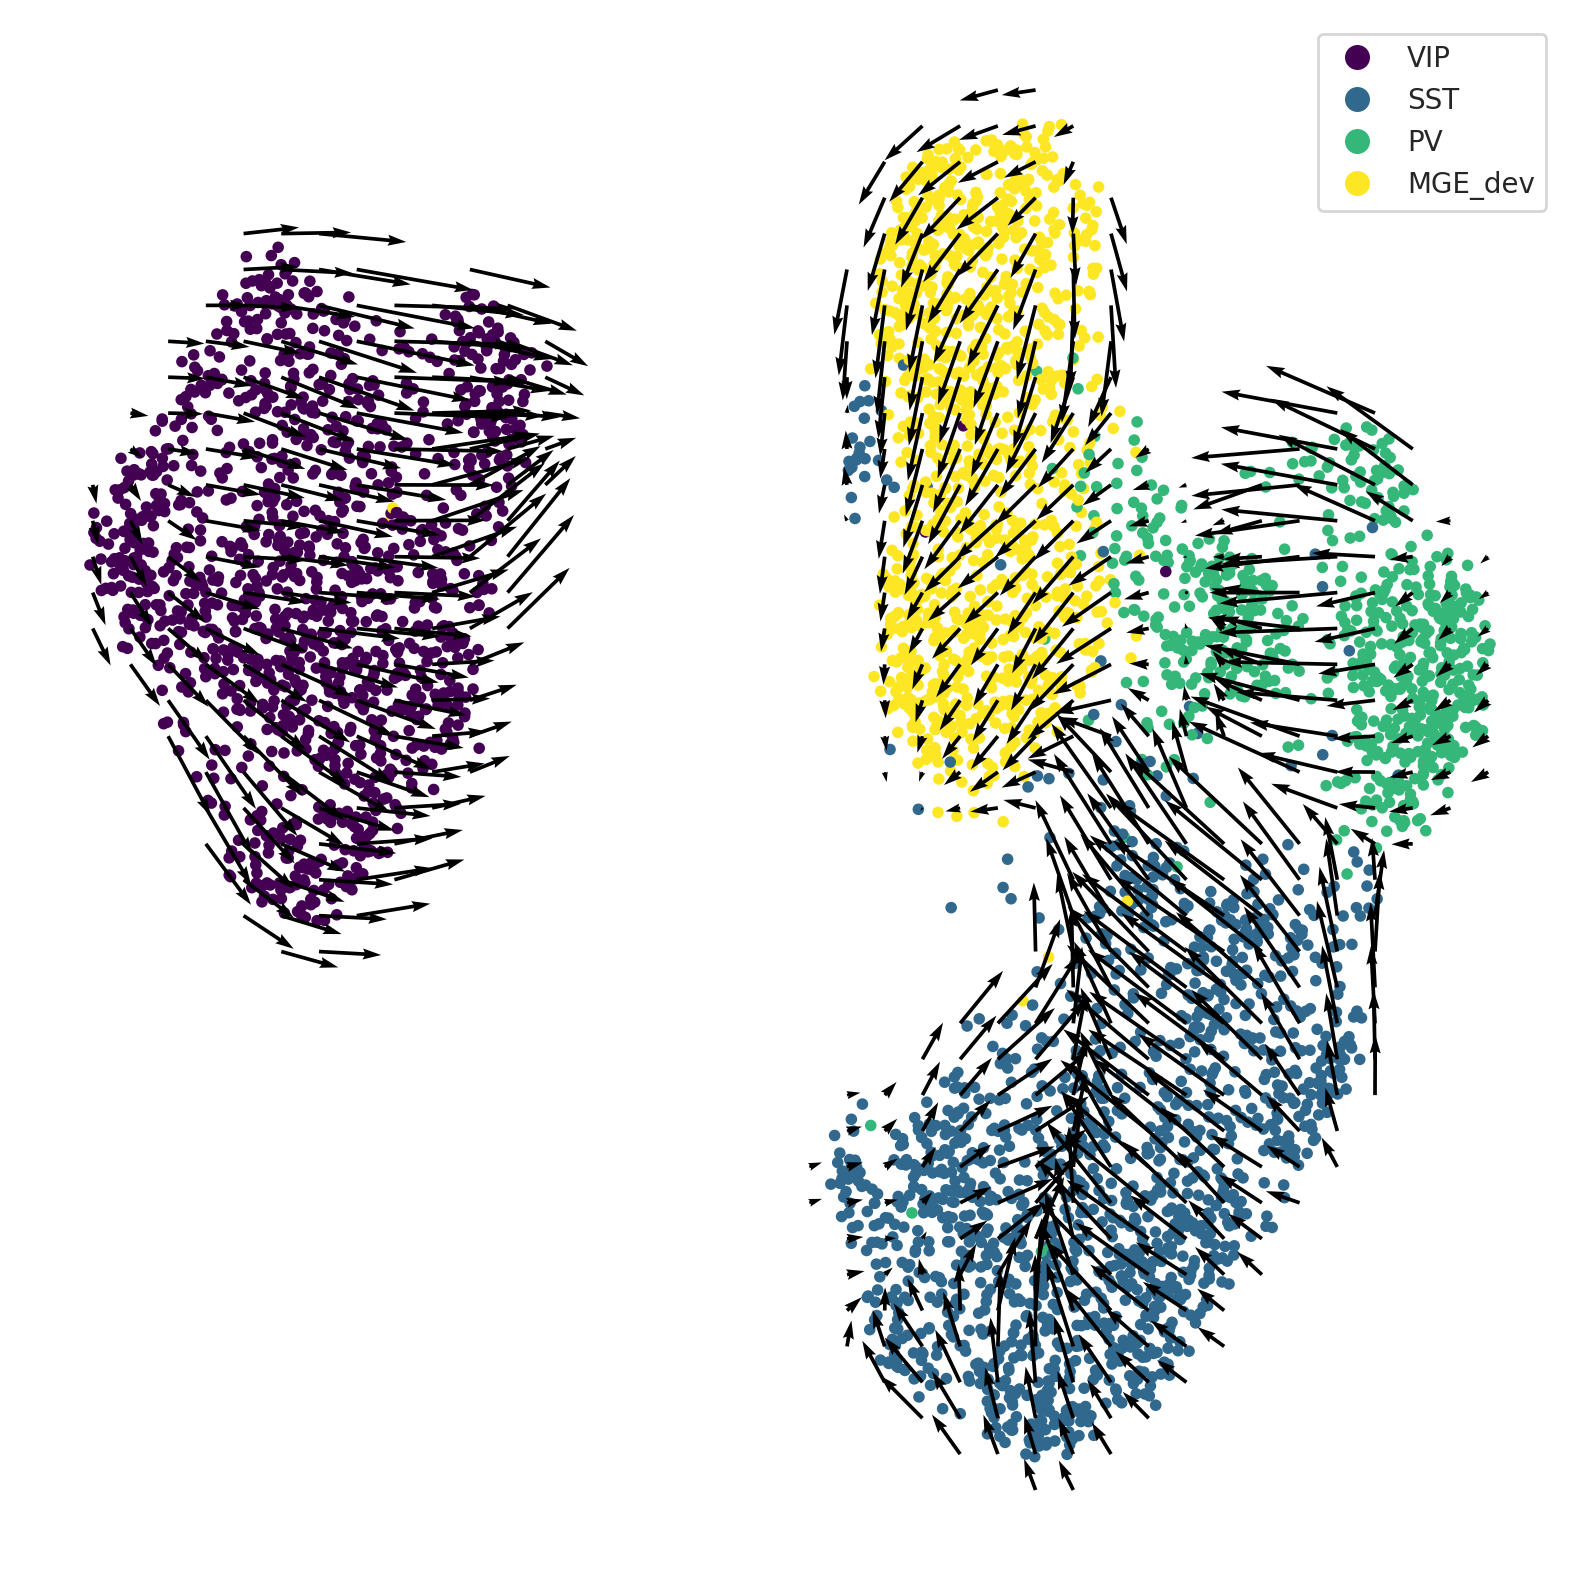

In [ ]:
plot_arrows_legend(oracle, labels='major_clust', scale=10, data_random=False, points_size = 10, filename=os.path.join(output_dir, "plot_simulation_flow_on_grid.png"))

In [ ]:
#file_name = os.path.join(output_dir, f"simulation_{goi}.celloracle.oracle")

In [ ]:
#Save checkpoint
#oracle.to_hdf5(file_name)

# Evaluate perturbation results

In [ ]:
# file_name = os.path.join(output_dir, f"Herring_simulation_{goi}.celloracle.oracle")
# oracle = co.load_hdf5(file_name)

In [ ]:
simulated_count = oracle.adata.layers["simulated_count"]

In [ ]:
original_count = oracle.adata.X.toarray()
log_fold_change = np.log2(simulated_count + 1) - np.log2(original_count + 1)

In [ ]:
print(log_fold_change.shape)
log_fold_change

(4422, 3002)


array([[ 0.02427562,  0.        ,  0.        , ...,  0.        ,
         0.01601152, -0.94301122],
       [ 0.0067799 ,  0.        ,  0.        , ...,  0.01343579,
         0.03639094, -0.97384232],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.02946392, -1.11775625],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.01077605,
         0.06076838, -0.97078174],
       [ 0.        ,  0.        ,  0.00437233, ...,  0.00412913,
         0.03189508, -0.92559856],
       [ 0.00378843,  0.        ,  0.00437233, ...,  0.00412913,
        -0.28143755, -0.88553345]])

In [ ]:
top_n = 1000

In [ ]:
cell_types = oracle.adata.obs['major_clust']
gene_names = oracle.adata.var_names

unique_cell_types = cell_types.unique()

table_data_list = []

for cell_type in unique_cell_types:
    # Get the indices of cells belonging to the current cell type
    cell_type_indices = np.where(cell_types == cell_type)[0]
    
    # Calculate the mean log fold change for each gene in the current cell type
    cell_type_log_fold_change = log_fold_change[cell_type_indices, :].mean(axis=0)
    
    # Calculate the absolute values of the mean log fold changes
    abs_cell_type_log_fold_change = np.abs(cell_type_log_fold_change)
    
    # Sort the absolute mean log fold changes in descending order
    sorted_indices = np.argsort(abs_cell_type_log_fold_change)[::-1]
    
    # Select the top_n genes based on the sorted indices
    top_gene_indices = sorted_indices[:top_n]
    top_genes = gene_names[top_gene_indices]
    
    top_log_fold_changes = cell_type_log_fold_change[top_gene_indices]
    
    cell_type_table_data = pd.DataFrame({
        'source': [cell_type] * top_n,
        'target': top_genes,
        'log_fold_change': top_log_fold_changes,
    })
    
    table_data_list.append(cell_type_table_data)

final_table_data_sim = pd.concat(table_data_list, ignore_index=True)

In [ ]:
final_table_data_sim['fold_change'] = np.exp2(final_table_data_sim['log_fold_change'])

final_table_data_sim.head()

source      target  log_fold_change  fold_change
0  MGE_dev        THRB        -0.545534     0.685138
1  MGE_dev  SNAP25-AS1         0.278857     1.213234
2  MGE_dev       ACTG1         0.160715     1.117841
3  MGE_dev      MPPED2         0.155810     1.114047
4  MGE_dev       GRID2         0.153550     1.112303

In [ ]:
# final_table_data_sim.to_csv(os.path.join(output_dir, f'final_table_data_sim_{goi}.csv'), index=False)

In [ ]:
# final_table_data_sim = pd.read_csv(os.path.join(output_dir, f'final_table_data_sim_{goi}.csv'))
# final_table_data_sim

source        target  log_fold_change  fold_change
0     MGE_dev          THRB        -0.545534     0.685138
1     MGE_dev    SNAP25-AS1         0.278857     1.213234
2     MGE_dev         ACTG1         0.160715     1.117841
3     MGE_dev        MPPED2         0.155810     1.114047
4     MGE_dev         GRID2         0.153550     1.112303
...       ...           ...              ...          ...
3995      SST  RP1-193H18.2         0.004328     1.003004
3996      SST         SULF1         0.004307     1.002990
3997      SST           ID4         0.004296     1.002982
3998      SST         HCAR1         0.004267     1.002962
3999      SST        GPR133         0.004266     1.002962

[4000 rows x 4 columns]

In [ ]:
print(list(final_table_data_sim.target))

['THRB', 'SNAP25-AS1', 'ACTG1', 'MPPED2', 'GRID2', 'MPP7', 'TRPC6', 'TUBB2B', 'EIF4A2', 'MAML3', 'HSPH1', 'ST6GALNAC5', 'PRKG1', 'GRIK1', 'CEBPZ', 'MAFB', 'HSP90AA1', 'NXPH2', 'RRP15', 'DDX5', 'RP11-242P2.1', 'BRINP2', 'WBSCR17', 'UBB', 'AC108142.1', 'LINC01122', 'CNTNAP4', 'WRN', 'SEMA6D', 'DLX6-AS1', 'MARCKS', 'RPS6KA5', 'KIAA0922', 'PCDH11X', 'SLC6A1-AS1', 'PRKAR2B', 'ZFAS1', 'RAB11A', 'ELMO1', 'ST8SIA2', 'TMSB4X', 'LHFPL3', 'PHF21B', 'SRGAP1', 'TMSB10', 'SLIT2', 'PDE5A', 'CFL1', 'SLC38A2', 'TTTY15', 'CDH11', 'TRHDE', 'UBE2D1', 'TMEFF2', 'RP1-78O14.1', 'TUBB2A', 'TMEM2', 'AC004158.2', 'PTPRT', 'BBX', 'ARX', 'PTGES3', 'NNAT', 'EEF2', 'PDE10A', 'MARCKSL1', 'ZC3H15', 'CXXC4', 'FGF13', 'HSPA8', 'KLF7', 'KDM1A', 'USP3', 'PTMS', 'SEMA6A', 'TERF2IP', 'PTMA', 'IGF2BP3', 'HSP90AB1', 'HMGN1', 'EZH2', 'PLCL1', 'HSPA1A', 'ALCAM', 'COL11A1', 'XPR1', 'BEX2', 'SDK1', 'DNAJB1', 'AMER2', 'TXNRD1', 'LRCH2', 'BCL11B', 'VGLL4', 'HN1', 'FIGN', 'TEAD1', 'SNTG2', 'HSPD1', 'PXDN', 'TXNDC16', 'TUBB', 'GRIA4

In [ ]:
cell_types = oracle.adata.obs['major_clust']
unique_cell_types = cell_types.unique()

tops = []

for cell_type in unique_cell_types:
    tops_df = final_table_data_sim[final_table_data_sim['source'] == cell_type][:5]
    tops.append(tops_df)

tops_df = pd.concat(tops, ignore_index=True)
tops_df

source      target  log_fold_change  fold_change
0   MGE_dev        THRB        -0.545534     0.685138
1   MGE_dev  SNAP25-AS1         0.278857     1.213234
2   MGE_dev       ACTG1         0.160715     1.117841
3   MGE_dev      MPPED2         0.155810     1.114047
4   MGE_dev       GRID2         0.153550     1.112303
5       VIP        THRB        -0.884867     0.541537
6       VIP        PCP4         0.521127     1.435076
7       VIP      MPPED2         0.516582     1.430562
8       VIP       PCDH7        -0.488421     0.712805
9       VIP      TUBB2B         0.422558     1.340302
10       PV        THRB        -0.665988     0.630257
11       PV       CDH18        -0.302747     0.810707
12       PV      DPYSL3         0.248456     1.187935
13       PV        EEF2         0.147518     1.107662
14       PV       CDK19         0.144376     1.105253
15      SST        THRB        -0.832026     0.561740
16      SST       FGF13         0.468895     1.384049
17      SST      TUBB2B         0.458597     1.374205
18      SST      DPYSL3         0.402947     1.322206
19      SST      MPPED2         0.366224     1.288974

# Get scores from `links`

In [ ]:
links_file_name = os.path.join(output_dir, "links_1.celloracle.links")

In [ ]:
links = co.load_hdf5(links_file_name)

In [ ]:
goi = "THRB"

THRB


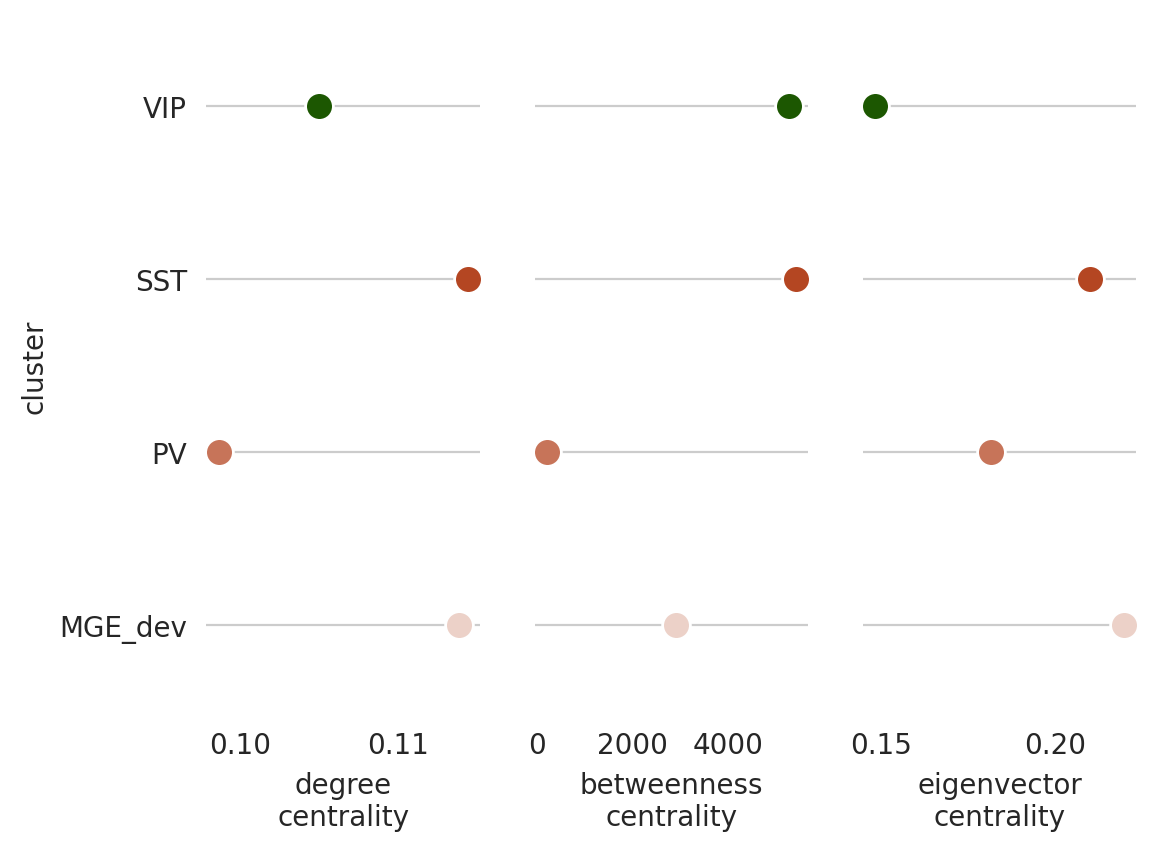

In [ ]:
links.plot_score_per_cluster(goi=goi)

In [ ]:
all_table_data = []

# Iterate over all cell types in the links.filtered_links dictionary
for celltype in links.filtered_links:
    # Get the GRN data for the current cell type
    grn_data = links.filtered_links[celltype]
    
    grn_data = grn_data[grn_data["source"] == goi]
    
    # Calculate the score for each row
    grn_data["score"] = -np.log10(grn_data["p"])
    
    grn_data["celltype"] = celltype
    
    grn_data = grn_data.rename(columns={"-logp": "X.logp"})
    
    table_data = grn_data[["source", "target", "coef_mean", "coef_abs", "p", "X.logp", "score", "celltype"]]
    
    all_table_data.append(table_data)

# Concatenate the table data from all cell types into a single DataFrame
final_table_data = pd.concat(all_table_data, ignore_index=True)

final_table_data.head()

source      target  coef_mean  coef_abs             p     X.logp  \
0     THRB       CDK19   0.076451  0.076451  1.011435e-10   9.995062   
1     THRB  SNAP25-AS1  -0.070439  0.070439  8.005107e-12  11.096633   
2     THRB       FGF13   0.068330  0.068330  1.635535e-15  14.786340   
3     THRB      MPPED2  -0.067948  0.067948  8.757158e-16  15.057637   
4     THRB       MAML3  -0.066508  0.066508  8.786552e-08   7.056182   
..     ...         ...        ...       ...           ...        ...   
297   THRB       FRAT2  -0.001230  0.001230  1.350516e-04   3.869500   
298   THRB        MFNG   0.001199  0.001199  3.040917e-06   5.516995   
299   THRB      ZNF764  -0.000732  0.000732  3.052181e-10   9.515390   
300   THRB      PKMYT1   0.000296  0.000296  2.240339e-04   3.649686   
301   THRB       SOGA3  -0.000026  0.000026  3.961188e-04   3.402175   

         score celltype  
0     9.995062  MGE_dev  
1    11.096633  MGE_dev  
2    14.786340  MGE_dev  
3    15.057637  MGE_dev  
4     7.056182  MGE_dev  
..         ...      ...  
297   3.869500      VIP  
298   5.516995      VIP  
299   9.515390      VIP  
300   3.649686      VIP  
301   3.402175      VIP  

[302 rows x 8 columns]

In [ ]:
# final_table_data.to_csv(os.path.join(output_dir, f'final_table_data_GRN_{goi}.csv'), index=False)

In [ ]:
# final_table_data = pd.read_csv(f'{folder}final_table_data_GRN.csv')

In [ ]:
# links.filtered_links['L2-3_CUX2'].source